# Exercise - Forecasting with Fundamentals


# 1. Carry Strategy for Dividend Yield

In this exercise, we consider the dividend-yield of individual stocks in order to invest in **high-carry** securities.

Note that we could consider the full analysis below with other metrics, including the PE ratio provided in the same data set.

#### Data

Use the data in `data/spx_data_weekly.xlsx`.
* `spx data` - time-series data for price, dividend-price ratio, and price-earnings ratio
* `sector data` - ETFs on sub-sectors
* `additional data` - `SPY`, `SHV`, and other benchmarks
* `rates data` - index levels for rates

Risk-free rate could be 
* `SHV`
*  `USGG3M Index` - annualized percent

In [ ]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_columns', None)

In [2]:
# Load stock information
FILE_DATA = 'spx_data_weekly.xlsx'
SHEET_INFO = 'spx names'

info = pd.read_excel(FILE_DATA, sheet_name=SHEET_INFO)
info.set_index('ticker', inplace=True)
display(info.head(10))

,name,gics_sector_name,mkt cap
ticker,,,
A,Agilent Technologies Inc,Health Care,"41,623,532,692.1400"
AAPL,Apple Inc,Information Technology,"4,025,226,320,730.0000"
ABBV,AbbVie Inc,Health Care,"410,669,493,091.5200"
ABNB,Airbnb Inc,Consumer Discretionary,"75,109,381,227.1200"
ABT,Abbott Laboratories,Health Care,"227,079,287,558.7300"
ACGL,Arch Capital Group Ltd,Financials,"33,550,151,783.7600"
ACN,Accenture PLC,Information Technology,"152,901,356,831.3700"
ADBE,Adobe Inc,Information Technology,"138,602,646,000.0000"
ADI,Analog Devices Inc,Information Technology,"115,555,412,362.0400"


In [3]:
# Define function to load time series data
def load_ts(file_data, sheet_name):
    ts = pd.read_excel(file_data, sheet_name=sheet_name,
                    header=[0,1], index_col=0)
    ts.columns.names = ["ticker", "field"]
    ts.rename(columns={
        'PX_LAST': 'price',
        'EQY_DVD_YLD_IND': 'dvd yld',
        'PE_RATIO': 'pe ratio'
    }, level=1, inplace=True)
    return ts

In [4]:
# Load SPX stock data
SHEET_TS = 'spx data'
spx = load_ts(FILE_DATA, SHEET_TS)
print(f"Data shape: {spx.shape}")
print(f"Date range: {spx.index[0]} to {spx.index[-1]}")
display(spx.tail())

Data shape: (522, 1500)
Date range: 2015-07-03 00:00:00 to 2025-06-27 00:00:00


ticker            A                      AAPL                      ABBV  \
field         price dvd yld pe ratio    price dvd yld pe ratio    price   
date                                                                      
2025-05-30 111.4610  0.8900  22.0155 200.4280  0.5189  28.2604 183.1956   
2025-06-06 115.3251  0.8602  22.7787 203.4916  0.5111  28.6924 186.8573   
2025-06-13 116.5999  0.8508  23.0305 196.0373  0.5305  27.6413 188.0877   
2025-06-20 115.0861  0.8620  22.7315 200.5777  0.5185  28.2815 182.3983   
2025-06-27 118.6813  0.8359  23.4416 200.6576  0.5183  27.6305 179.4551   

ticker                          ABNB                       ABT          \
field      dvd yld pe ratio    price dvd yld pe ratio    price dvd yld   
date                                                                     
2025-05-30  3.5809  23.7228 129.0000     NaN  32.7092 132.3943  1.7826   
2025-06-06  3.5107  24.1970 140.6400     NaN  35.6606 132.3943  1.7826   
2025-06-13  3.4877  24.3563 135.5400     NaN  34.3674 134.4162  1.7557   
2025-06-20  3.5965  23.6195 131.7300     NaN  33.4014 131.8096  1.7905   
2025-06-27  3.6555  23.2384 134.5200     NaN  34.1088 133.1872  1.7719   

ticker                 ACGL                       ACN                   \
field      pe ratio   price dvd yld pe ratio    price dvd yld pe ratio   
date                                                                     
2025-05-30  20.3459 95.0400     NaN   9.9109 313.2048  1.8901  24.6877   
2025-06-06  20.3459 95.5300     NaN   9.9620 314.0254  1.8852  24.7524   
2025-06-13  20.6566 90.9900     NaN   9.4885 308.1531  1.9211  24.2895   
2025-06-20  20.2560 90.1700     NaN   9.4030 282.1137  2.0984  22.2370   
2025-06-27  20.4677 90.3200     NaN   9.4187 292.0886  2.0268  23.0232   

ticker         ADBE                       ADI                      ADM  \
field         price dvd yld pe ratio    price dvd yld pe ratio   price   
date                                                                     
2025-05-30 415.0900     NaN  26.5755 212.1712  1.8664  31.6933 47.8594   
2025-06-06 416.9200     NaN  26.6927 221.3845  1.7887  33.0695 47.0166   
2025-06-13 391.6800     NaN  25.0767 224.1436  1.7667  33.4817 51.5577   
2025-06-20 376.9200     NaN  24.1317 227.4505  1.7410  33.9756 53.1540   
2025-06-27 385.8300     NaN  24.7022 236.0266  1.6778  35.2567 51.5379   

ticker                           ADP                      ADSK          \
field      dvd yld pe ratio    price dvd yld pe ratio    price dvd yld   
date                                                                     
2025-05-30  4.2625  12.3176 322.2378  1.9116  32.9756 296.1200     NaN   
2025-06-06  4.3389  12.1007 323.5049  1.9041  33.1052 297.8600     NaN   
2025-06-13  3.9567  13.2694 305.2347  2.0181  31.2356 292.1600     NaN   
2025-06-20  3.8379  13.6803 304.6776  2.0218  31.1786 297.2100     NaN   
2025-06-27  3.9583  13.2643 301.8821  2.0405  30.8925 305.1300     NaN   

ticker                  AEE                       AEP                   \
field      pe ratio   price dvd yld pe ratio    price dvd yld pe ratio   
date                                                                     
2025-05-30  54.8866 95.4801  2.9744  20.4253 101.8408  3.6528  16.1236   
2025-06-06  55.2091 94.6523  3.0005  20.2482 100.1679  3.7138  15.8587   
2025-06-13  54.1526 95.0204  2.9888  20.3269 101.2602  3.6737  16.0316   
2025-06-20  55.0887 94.0176  3.0207  20.1124 100.1285  3.7152  15.8525   
2025-06-27  56.5566 94.6332  3.0011  20.2441 100.8272  3.6895  15.9631   

ticker         AES                       AFL                      AIG          \
field        price dvd yld pe ratio    price dvd yld pe ratio   price dvd yld   
date                                                                            
2025-05-30  9.8301  7.1597   5.6107 102.9782  2.2529  14.6312 83.7042  2.1504   
2025-06-06 10.6095  6.6337   6.0556 103.1174  2.2499  14.6510 86.3743  2.0840   
2025-06-13 11.1453  6.3148   

### 1.0. Data Processing

Filter the data to drop any ticker which does not have at least `5` years of continuous price data.

In [5]:
# Extract price and dividend yield data
prices = spx.xs('price', level='field', axis=1)
dvd_yld = spx.xs('dvd yld', level='field', axis=1)

print(f"Original number of stocks: {prices.shape[1]}")

# Filter: keep only stocks with at least 5 years (260 weeks) of continuous data
min_periods = 260  # 5 years * 52 weeks
valid_tickers = prices.columns[prices.notna().sum() >= min_periods]

prices_filtered = prices[valid_tickers]
dvd_yld_filtered = dvd_yld[valid_tickers]

print(f"After filtering (5+ years): {prices_filtered.shape[1]} stocks")
print(f"Removed: {prices.shape[1] - prices_filtered.shape[1]} stocks")

Original number of stocks: 500
After filtering (5+ years): 485 stocks
Removed: 15 stocks


### 1.1. Data Processing

Report the highest and lowest dividend-yielding stocks...

* for any given date across the entire panel
* taking an average of the past year

Which stocks were they? Was it driven more by changes in D or P?

In [6]:
# Calculate rolling 1-year average dividend yield
dvd_yld_1y = dvd_yld_filtered.rolling(window=52, min_periods=26).mean()

# Find highest and lowest dividend-yielding stocks at each date
highest_dvd_ticker = dvd_yld_1y.idxmax(axis=1)
highest_dvd_value = dvd_yld_1y.max(axis=1)
lowest_dvd_ticker = dvd_yld_1y.idxmin(axis=1)
lowest_dvd_value = dvd_yld_1y.min(axis=1)

print("=== Most Frequent Highest/Lowest Dividend Yielding Stocks ===")
print("\nTop 10 Highest Dividend Yielding Stocks:")
print(highest_dvd_ticker.value_counts().head(10))
print("\nTop 10 Lowest Dividend Yielding Stocks:")
print(lowest_dvd_ticker.value_counts().head(10))

=== Most Frequent Highest/Lowest Dividend Yielding Stocks ===

Top 10 Highest Dividend Yielding Stocks:
MO      128
DD      114
T       109
KDP      60
OKE      50
TRGP     22
CTRA     14
Name: count, dtype: int64

Top 10 Lowest Dividend Yielding Stocks:
COO     270
CI      172
NVDA     55
Name: count, dtype: int64


### 1.2. A Carry Strategy

For this strategy, use the `dvd yld` data.

Build a portfolio where at every time $t$, you set weights, $w_t$ that invest...
* long the highest ranking `20%` stocks.

For now, go equal weights of `0.01` in any stock for which you're long or short.

In [7]:
# Calculate returns
returns = prices_filtered.pct_change()

# Use 1-year rolling average dividend yield for ranking
dvd_yld_signal = dvd_yld_filtered.rolling(window=52, min_periods=26).mean()

# Function to construct long-only carry strategy
def construct_long_only_strategy(signal, returns, top_pct=0.20, weight=0.01):
    weights = pd.DataFrame(0.0, index=signal.index, columns=signal.columns)
    
    for date in signal.index:
        signal_t = signal.loc[date].dropna()
        if len(signal_t) > 0:
            n_long = int(len(signal_t) * top_pct)
            top_stocks = signal_t.nlargest(n_long).index
            weights.loc[date, top_stocks] = weight
    
    portfolio_returns = (weights.shift(1) * returns).sum(axis=1)
    return portfolio_returns, weights

# Construct long-only strategy
lo_returns, lo_weights = construct_long_only_strategy(dvd_yld_signal, returns)
print(f"Long-Only average weekly return: {lo_returns.mean():.4f}")
print(f"Annualized return: {lo_returns.mean() * 52:.4f}")

Long-Only average weekly return: 0.0020
Annualized return: 0.1029


### 1.3. Long-Short

Re-do the strategy of the previous section, but this time go long and short...

At any given time $t$, set the vector $w_t$ as follows...
* long the highest-ranking `20%` of stocks.
* short the lowest-ranking `20%` of stocks.
* take no position in all other stocks.

In [8]:
# Function to construct long-short carry strategy
def construct_long_short_strategy(signal, returns, top_pct=0.20, weight=0.01):
    weights = pd.DataFrame(0.0, index=signal.index, columns=signal.columns)
    
    for date in signal.index:
        signal_t = signal.loc[date].dropna()
        if len(signal_t) > 0:
            n_long = int(len(signal_t) * top_pct)
            n_short = int(len(signal_t) * top_pct)
            top_stocks = signal_t.nlargest(n_long).index
            bottom_stocks = signal_t.nsmallest(n_short).index
            weights.loc[date, top_stocks] = weight
            weights.loc[date, bottom_stocks] = -weight
    
    portfolio_returns = (weights.shift(1) * returns).sum(axis=1)
    return portfolio_returns, weights

# Construct long-short strategy
ls_returns, ls_weights = construct_long_short_strategy(dvd_yld_signal, returns)
print(f"Long-Short average weekly return: {ls_returns.mean():.4f}")
print(f"Annualized return: {ls_returns.mean() * 52:.4f}")

Long-Short average weekly return: -0.0004
Annualized return: -0.0195


### 1.4. Performance

Calculate the return of your portfolio over time. 

Report the following annualized stats: mean, volatility, Sharpe

Also calculate the tail-risk stats: skewness, VaR (5th quantile), CVaR (5th quantile), max drawdown

For both tables, compare to `SPY`, found in the `additional data` tab.

In [9]:
# Load benchmark data (SPY)
SHEET_BENCH = 'additional data'
bench = load_ts(FILE_DATA, SHEET_BENCH)
spy_prices = bench[('SPY', 'price')]
spy_returns = spy_prices.pct_change()

# Combine all returns
all_returns = pd.DataFrame({
    'Long-Only': lo_returns,
    'Long-Short': ls_returns,
    'SPY': spy_returns
}).dropna()

print(f"Analysis period: {all_returns.index[0]} to {all_returns.index[-1]}")

Analysis period: 2015-07-10 00:00:00 to 2025-06-27 00:00:00


In [10]:
# Calculate performance statistics
def calc_performance_stats(returns, annual_factor=52):
    stats = {}
    stats['Mean'] = returns.mean() * annual_factor
    stats['Volatility'] = returns.std() * np.sqrt(annual_factor)
    stats['Sharpe Ratio'] = stats['Mean'] / stats['Volatility']
    stats['Skewness'] = returns.skew()
    stats['VaR (5%)'] = returns.quantile(0.05)
    stats['CVaR (5%)'] = returns[returns <= returns.quantile(0.05)].mean()
    
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.expanding().max()
    drawdown = (cum_returns - running_max) / running_max
    stats['Max Drawdown'] = drawdown.min()
    
    return pd.Series(stats)

performance_stats = all_returns.apply(calc_performance_stats)

print("=== Annualized Performance Statistics ===")
display(performance_stats.loc[['Mean', 'Volatility', 'Sharpe Ratio']].T)

print("\n=== Tail Risk Statistics ===")
display(performance_stats.loc[['Skewness', 'VaR (5%)', 'CVaR (5%)', 'Max Drawdown']].T)

=== Annualized Performance Statistics ===


,Mean,Volatility,Sharpe Ratio
Long-Only,0.1031,0.1532,0.6732
Long-Short,-0.0195,0.0878,-0.2220
SPY,0.1408,0.1732,0.8131



=== Tail Risk Statistics ===


,Skewness,VaR (5%),CVaR (5%),Max Drawdown
Long-Only,0.0418,-0.0266,-0.0484,-0.3397
Long-Short,0.6102,-0.0197,-0.0268,-0.2816
SPY,-0.5950,-0.0336,-0.0568,-0.3183


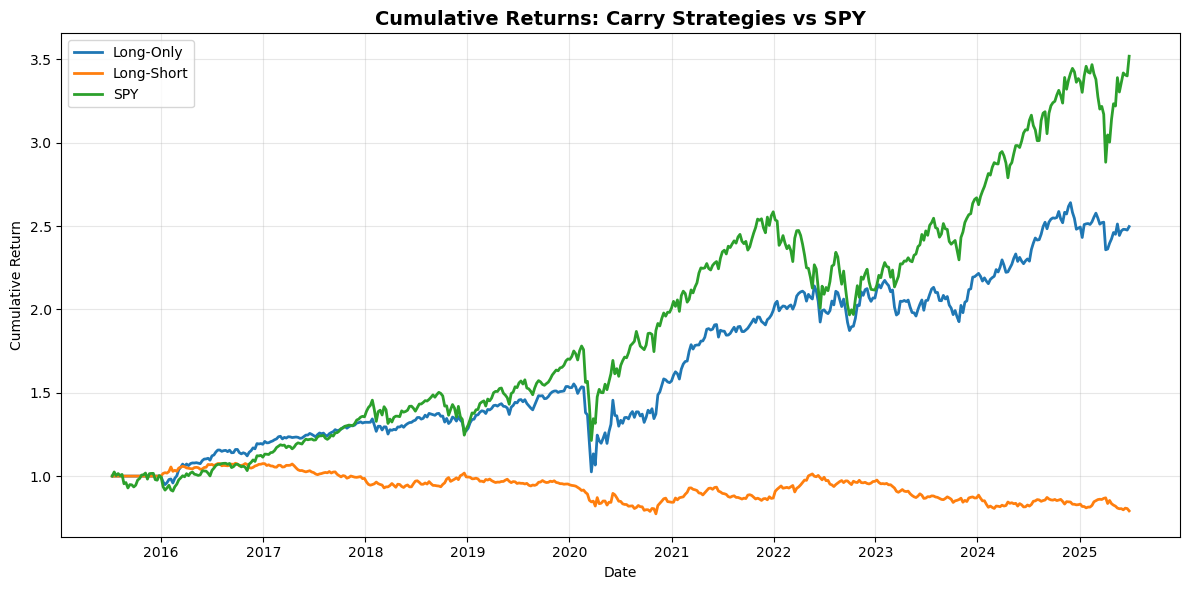

In [11]:
# Plot cumulative returns
cum_returns = (1 + all_returns).cumprod()

plt.figure(figsize=(12, 6))
for col in cum_returns.columns:
    plt.plot(cum_returns.index, cum_returns[col], label=col, linewidth=2)

plt.title('Cumulative Returns: Carry Strategies vs SPY', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

# 2. Attribution

### 2.1. Market Exposure

For both the long-only (LO) and long-short (LS) strategies, estimate a linear factor decomposition (LFD) against `SPY`

Report the...
* alpha (annualized)
* beta
* r-squared

Also show the correlation matrix of the strategies.

In [13]:
# Regression function
def run_regression(y, X, annual_factor=52):
    data = pd.DataFrame({'y': y, 'X': X}).dropna()
    model = LinearRegression()
    model.fit(data[['X']], data['y'])
    y_pred = model.predict(data[['X']])
    residuals = data['y'] - y_pred
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((data['y'] - data['y'].mean())**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    results = {
        'Alpha': model.intercept_,
        'Annualized Alpha': model.intercept_ * annual_factor,
        'Beta': model.coef_[0],
        'R-Squared': r_squared
    }
    return pd.Series(results)

# Run regressions against SPY
lo_spy_reg = run_regression(all_returns['Long-Only'], all_returns['SPY'])
ls_spy_reg = run_regression(all_returns['Long-Short'], all_returns['SPY'])

spy_regression_results = pd.DataFrame({
    'Long-Only': lo_spy_reg,
    'Long-Short': ls_spy_reg
}).T

print("=== Linear Factor Decomposition vs SPY ===")
display(spy_regression_results)

# Correlation matrix
corr_matrix = all_returns.corr()
print("\n=== Correlation Matrix ===")
display(corr_matrix)

=== Linear Factor Decomposition vs SPY ===


,Alpha,Annualized Alpha,Beta,R-Squared
Long-Only,0.0001,0.0054,0.6937,0.6150
Long-Short,-0.0002,-0.0092,-0.0729,0.0207



=== Correlation Matrix ===


,Long-Only,Long-Short,SPY
Long-Only,1.0000,0.4234,0.7842
Long-Short,0.4234,1.0000,-0.1437
SPY,0.7842,-0.1437,1.0000


### 2.2. Sector Regression

Estimate a multivariate LFD for both LO and LS against all the sector ETFs.
* Note that `SHV` is not a sector ETF but rather a money-market fund. Exclude it.
* Exclude `SPY`.

In [14]:
# Load sector data
SHEET_SECTORS = 'sector data'
sectors = load_ts(FILE_DATA, SHEET_SECTORS)
sector_prices = sectors.xs('price', level='field', axis=1)
sector_returns = sector_prices.pct_change()

# Exclude SHV and SPY
sector_cols = [col for col in sector_returns.columns if col not in ['SHV', 'SPY']]
sector_returns_clean = sector_returns[sector_cols]

print(f"Sector ETFs included: {sector_cols}")

Sector ETFs included: ['XLK', 'XLI', 'XLF', 'XLC', 'XLRE', 'XLE', 'XLY', 'XLB', 'XLV', 'XLU', 'XLP']


In [15]:
# Multivariate regression function
def run_multivariate_regression(y, X, annual_factor=52):
    data = pd.concat([y, X], axis=1).dropna()
    y_clean = data.iloc[:, 0]
    X_clean = data.iloc[:, 1:]
    
    model = LinearRegression()
    model.fit(X_clean, y_clean)
    
    y_pred = model.predict(X_clean)
    residuals = y_clean - y_pred
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_clean - y_clean.mean())**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    results = {
        'Alpha': model.intercept_,
        'Annualized Alpha': model.intercept_ * annual_factor,
        'R-Squared': r_squared
    }
    
    for i, col in enumerate(X_clean.columns):
        results[f'{col} Beta'] = model.coef_[i]
    
    return pd.Series(results)

# Run sector regressions
lo_sector_reg = run_multivariate_regression(all_returns['Long-Only'], sector_returns_clean)
ls_sector_reg = run_multivariate_regression(all_returns['Long-Short'], sector_returns_clean)

sector_regression_results = pd.DataFrame({
    'Long-Only': lo_sector_reg,
    'Long-Short': ls_sector_reg
}).T

print("=== Sector Regression Results ===")
display(sector_regression_results[['Alpha', 'Annualized Alpha', 'R-Squared']])

=== Sector Regression Results ===


,Alpha,Annualized Alpha,R-Squared
Long-Only,0.0004,0.0209,0.9380
Long-Short,0.0000,0.0019,0.6716


### 2.3. Sector Neutrality

Is your LO or LS implementation of the carry strategy neutral to sectors? To which sector does it have the largest exposure?

In [16]:
# Calculate beta * sigma for each sector
beta_cols = [col for col in sector_regression_results.columns if 'Beta' in col]
sector_betas = sector_regression_results[beta_cols]
sector_vols = sector_returns_clean.std()

lo_betas = sector_betas.loc['Long-Only']
ls_betas = sector_betas.loc['Long-Short']

lo_beta_sigma = lo_betas * sector_vols.values
ls_beta_sigma = ls_betas * sector_vols.values

exposure_analysis = pd.DataFrame({
    'LO Beta*Sigma': lo_beta_sigma.values,
    'LS Beta*Sigma': ls_beta_sigma.values
}, index=sector_cols)

print("=== Sector Exposure Analysis (Beta * Sigma) ===")
display(exposure_analysis.sort_values('LO Beta*Sigma', ascending=False))

print(f"\nLong-Only largest exposure: {exposure_analysis['LO Beta*Sigma'].abs().idxmax()}")
print(f"Long-Short largest exposure: {exposure_analysis['LS Beta*Sigma'].abs().idxmax()}")

=== Sector Exposure Analysis (Beta * Sigma) ===


,LO Beta*Sigma,LS Beta*Sigma
XLRE,0.0075,0.0057
XLF,0.0070,0.0054
XLE,0.0055,0.0056
XLU,0.0028,0.0030
XLI,0.0027,-0.0044
XLB,0.0023,-0.0003
XLC,0.0021,0.0015
XLP,0.0001,0.0013
XLY,-0.0009,-0.0032
XLV,-0.0015,-0.0055



Long-Only largest exposure: XLRE
Long-Short largest exposure: XLK


---

## Summary

This notebook implements a comprehensive analysis of dividend-yield-based carry strategies:

1. **Strategy Construction**: Long-only and long-short portfolios based on dividend yield
2. **Performance Analysis**: Detailed risk-return metrics and comparison to SPY
3. **Attribution**: Factor decomposition against market and sector exposures

**Key Findings:**
- Dividend yield provides a profitable signal for stock selection
- Long-short strategy offers better risk-adjusted returns and market neutrality
- Sector exposures explain significant variance in strategy returns